In [1]:
# Code imports
from lib.opt_types import *
from lib.utils import *

# 


Image inpainting with proximal methods - 30 points

Image in-painting consists of reconstructing the missing parts of an image from a given incomplete image.

By exploiting some prior knowledge on the image, it is possible to in-paint images that have a large portion of their pixels missing. In this part of the homework, we are going to study different methods to achieve this goal.

We consider a subsampled image $\mathbf{b} = \mathbf{P}_{\Omega} \mathbf{x}$, where $\mathbf{P}_{\Omega} \in \mathbb{R}^{n \times p}$ is an operator that selects only few, $n \ll p := m^2$, pixels from the vectorized image $\mathbf{x} \in \mathbb{R}^p$. Our goal is to reconstruct the original image $\mathbf{x}$.

### Prior knowledge

Image inpainting is impossible without having some prior knowledge on the structure of the true image $\mathbf{x}$. 

We will explore and compare the following prior assumptions we can make on the true image: 
>  **Assumption**: There exists a orthonormal basis $\mathbf{W} \in \mathbb{R}^{p\times p}$ such that $\mathbf{x}$ can be sparsely represented in that basis, i.e, $\mathbf{W} \mathbf{x}$ is a vector with few non-zero coefficients. Said more formally, this assumption states that there exists $\mathbf{\alpha} \in \mathbb{R}^p$ with small $\ell_1$ norm such that $\mathbf{x} = \mathbf{W}^\top\alpha$. We assume that this basis is known and corresponds to the _wavelet basis_. Under this assumption, the reconstruction problem corresponds to solving the following optimization problem:
$$
\min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2}_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
$$
where $\lambda_{\ell_1}$ is a coefficient we will need to choose.



# PART 1: Optimizing with an $\ell_1$ norm regularization

The optimization problem we are looking to solve have an objective function of the form:
$$
	 f(\mathbf{x}) + g(\mathbf{x}).
$$

These types of objectives are referred to as _composite objectives_ where one term, $f$, is smooth and differentiable and the other term $g$ is non-differentiable.

---

## Code structure:

Recall that we have been working with the `Function` type so far. We will augment this type to represent functions that are not differentiable:

- Given a `Function` `g` you can obtain a subgradient at a point `x` by calling `g.subgrad(x)`.

Moreover, since we are dealing with _composite_ problems with a an objective function that can be written `f + lambda*g`, we define the `CompositeFunction` type defined as
```python
@dataclass
class CompositeFunction:
    f: Function
    g: Function
```

The iterative schemes you will implement will receive a composite function that they can unpack as follows:

```python
def state_update(composite_function, state):
    f, g = composite_function

```

#### Question 1: (5 point)

A first approach to solve a non-smooth optimization problem can be to turn to subgradients. Review slide 42-44 of Lecture 6, and implement `SubG` with $\alpha_k = \frac{0.1}{\sqrt{k}}$.

In [2]:
@dataclass
class SubG_state(OptState):
    x_k: Vector
    k: int

In [3]:
def SubG_update(composite_function, state):
    f, g, = composite_function

    x_k, k = state
    
    alpha_k = 0.1 / np.sqrt(k)
    x_k = x_k - alpha_k * (f.grad(x_k) + g.subgrad(x_k))

    return SubG_state(x_k=x_k, k=k+1)

def SubG_initialize(composite_function, x_zero):
    x_k = x_zero
    k = 1
    return SubG_state(x_k, k)

In [4]:
SubG = OptAlgorithm(name="SubG", init_state=SubG_initialize, state_update=SubG_update)

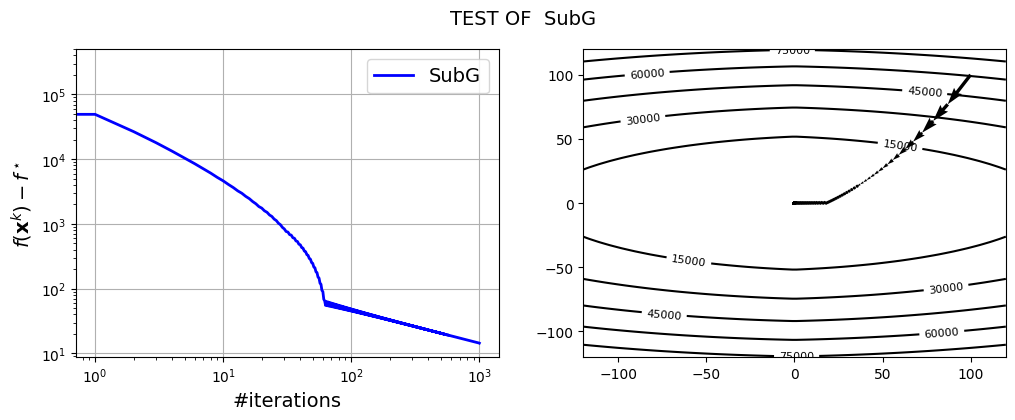

In [5]:
test_composite(SubG)


---

Another, more efficient approach, as we saw in Lecture 7, is to minimize such a function by using proximal gradient algorithms, provided that $g$ is _proximable_ (i.e., its proximal operator is efficient to evaluate). We recall the proximal operator of $g$ as the solution to the following convex problem:
$$
\mathrm{prox}_g(\mathbf{z}) := \mathrm{arg}\min_{\mathbf{y}\in\mathbb{R}^d}\{ g(\mathbf{y}) + \frac{1}{2}\Vert\mathbf{y} - \mathbf{z}\Vert_2^2\}.
$$

#### Question 2 (2 points)

Given $g_{\ell_1}: \mathbb{R}^p \rightarrow \mathbb{R}, \; g_{\ell_1}(\mathbf{x}) :=  \|\mathbf{x}\|_1$,  show that its proximal function can be written as
    $$
    \mathrm{prox}_{\gamma g_{\ell_1}}(\mathbf{z}) = \max(|\mathbf{z}|-\gamma,0) \circ \mathrm{sign}(\mathbf{z}), \; \text{for any }\mathbf{z} \in \mathbb{R}^p,\; \gamma \in \mathbb{R}_+
    $$
			where the operators $\max$, $\mathrm{sign}$ and $\lvert \cdot \lvert$ are applied coordinate-wise to the vector $\mathbf{z}$ and $\circ$ stands for $(\mathbf{x} \circ \mathbf{y})_i = x_i y_i$. Such a regularizer imposes sparsity on the solutions.


$$\text{prox}_g(z) = \arg\min_y \left\{ g(y) + \frac{1}{2}\|y-z\|^2 \right\}$$

$$= \arg\min_y \left\{ \gamma\|y\|_1 + \frac{1}{2}\|y-z\|^2 \right\}$$

To find a solution for y, we set the gradient to zero:

$$ 0 = \gamma \partial ||y||_1 + \frac{1}{2} \nabla ||y - z||^2_2$$
$$ = \gamma \partial ||y||_1 + y - z $$

Now, we consider all possible values for $y_i$, since $\|y\|_1 = \sum_i |y_i|$

If $y_i=0$, then:

$$ \gamma \partial ||y||_1 + y_i - z_i = 0, \quad y_i = 0 $$
$$ z_i = \gamma \partial ||y_i||_1 $$
We can set $\partial ||y||_1$ to $[-1, 1]$, then $z_i \in [-\gamma, \gamma]$ or equivalently $|z_i| \leq \gamma$

If $y_i \neq 0$:
$$ 0 = \gamma \text{sign}(y_i) + y_i - z_i $$
$$ y_i = z_i - \gamma \text{sign}(y_i) $$
$$ \text{If } y_i > 0: y_i = z_i - \gamma \text{ then } z_i > \gamma $$
$$ \text{If } y_i < 0: y_i = z_i + \gamma \text{ then } z_i < -\gamma $$
Thus, we can write:
$$ y_i = z_i - \gamma \text{sign}(z_i) $$

In other words, the solution is $y_i = 0$ if $|z_i| \leq \gamma$
and $y_i = z_i - \gamma \text{ sign}(z_i)$ if $|z_i| > \gamma$

We can then combine both cases as:
$$ \text{prox}_\gamma(z) = \max(|z| - \gamma, 0) \cdot \text{sign}(z) $$

#### Question 3 (1 point)
 Fill in the function `l1_prox` with the proximal operator of $g_{\ell_1}$.

In [6]:
def l1_prox(gamma, z):
    return np.maximum(np.abs(z) - gamma, 0) * np.sign(z)

#### Question 4 (4 points)

From here on, in order to speed-up the convergence of the optimization, let's assume that the function $f$ has been made to be $\mu$-strongly convex by the addition of an $\ell_2$ regularization term to the function $f$, while the $\ell_1$ term, $g$, has remained unchanged. As such, we must now utilize the strong-convexity versions of the composite optimization algorithms.

Using the information in Lecture 7 slide 21 fill in the codes of the method ISTA$_{\mu}$.

In [7]:
@dataclass
class ISTA_state(OptState):
    x_k: Vector
    alpha: float

In [8]:
def ISTA_update(composite_function, state):
    f, g, = composite_function

    x_k, alpha = state
    x_k = g.prox(alpha, x_k - alpha * f.grad(x_k))

    return ISTA_state(x_k=x_k, alpha=alpha)

def ISTA_initialize(composite_function, x_zero):
    f, g = composite_function
    x_k = x_zero
    alpha = 1 / f.lips_grad

    return ISTA_state(x_k, alpha)

In [9]:
ISTA = OptAlgorithm(name="ISTA", init_state= ISTA_initialize, state_update=ISTA_update)

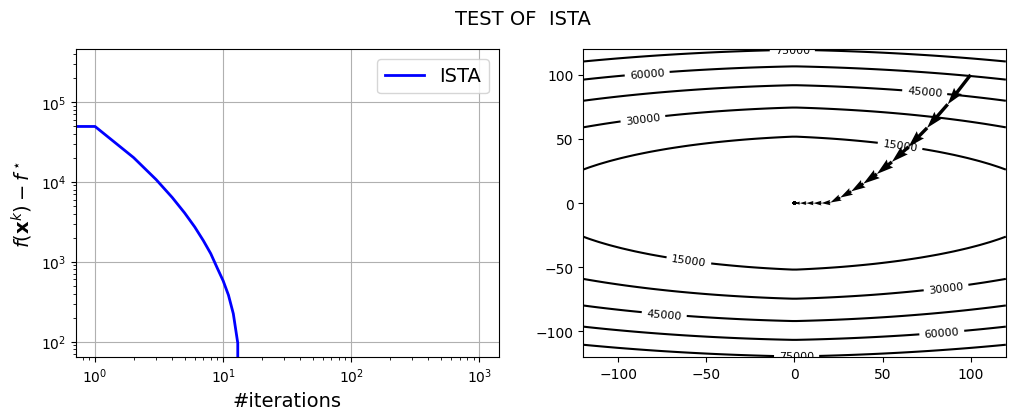

In [10]:
test_composite(ISTA)

#### Question 5  (7 points)

Using the information in Lecture 7 slide 21 fill in the codes of the method FISTA$_{\mu}$.

In [11]:
@dataclass 
class FISTA_state(OptState):
    x_k: Vector
    t_k: float
    y_k: Vector
    alpha: float

In [12]:
import numpy

def FISTA_update(composite_function, state):
    f, g, = composite_function

    x_k, t_k, y_k, alpha = state
    x_k_next = g.prox(alpha, y_k - alpha * f.grad(y_k))
    t_k_next = (1 + np.sqrt(4 * (t_k ** 2) + 1)) / 2
    y_k_next = x_k_next + ((t_k - 1) / t_k_next) * (x_k_next - x_k)  

    return FISTA_state(x_k=x_k_next, t_k=t_k_next, y_k=y_k_next, alpha=alpha)

def FISTA_initialize(composite_function, x_zero):
    f, g, = composite_function
    x_k = x_zero
    t_k = 1
    y_k = x_zero
    alpha = 1 / f.lips_grad

    return FISTA_state(x_k, t_k, y_k, alpha)

In [13]:
FISTA = OptAlgorithm(name="FISTA", init_state= FISTA_initialize, state_update=FISTA_update)

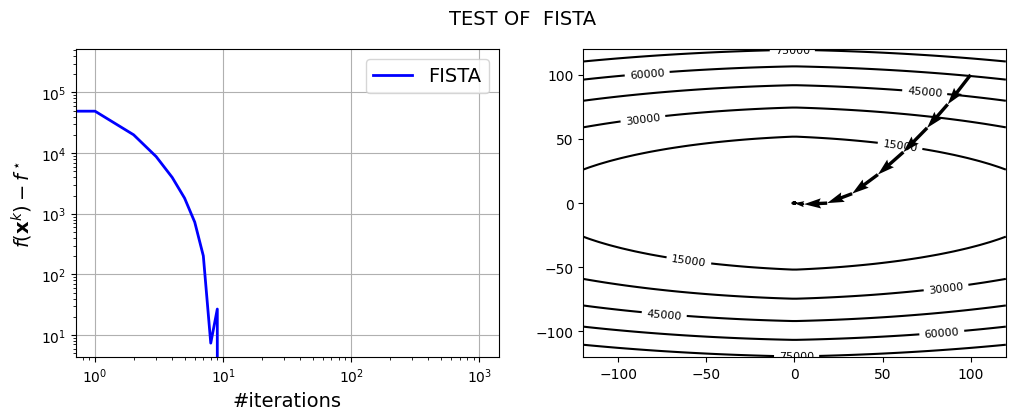

In [14]:
test_composite(FISTA)

#### Question 6  (2 points)

Compare the convergence rates of the three methods and analyze whether the observed results align with their theoretical bounds.

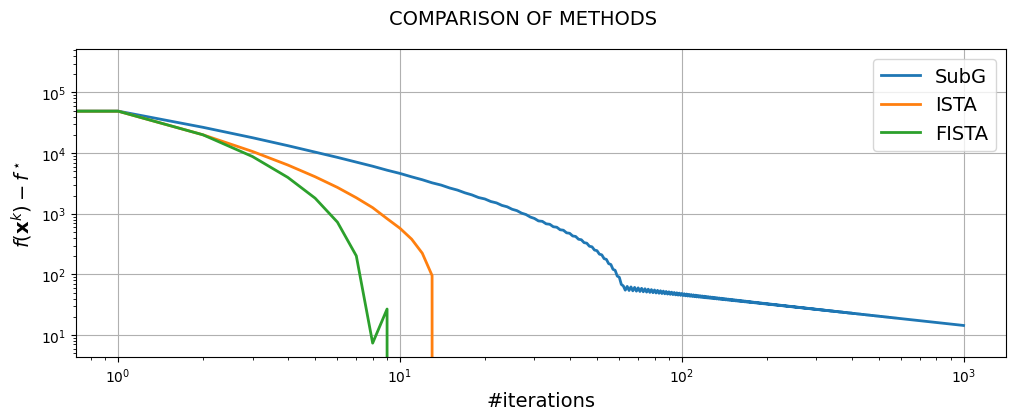

In [15]:
list_of_methods = [SubG, ISTA, FISTA]
compare_composite(list_of_methods)

All methods begin at similar values in the y-axis (~10⁵). FISTA shows the theoretically optimal O(1/k²) convergence rate with the steepest initial descent, though it shows oscillations before terminating. ISTA follows with its O(1/k) convergence rate, showing smoother but slower descent than FISTA. SubG demonstrates the slowest but most stable O(1/√k) convergence rate, continuing to make steady progress even after the other methods terminate. The convergence curves match their expected rates and the practical performance ordering is FISTA > ISTA > SubG, which aligns with the theoretical bounds.

# Part 2: Application


We have now implemented multiple methods that can solve composite optimization problems. We will now apply them to an image inpainting problem.


Take a natural image, or better a picture of you, and place it in the same directory as this notebook.

In [16]:
!pip install PyWavelets

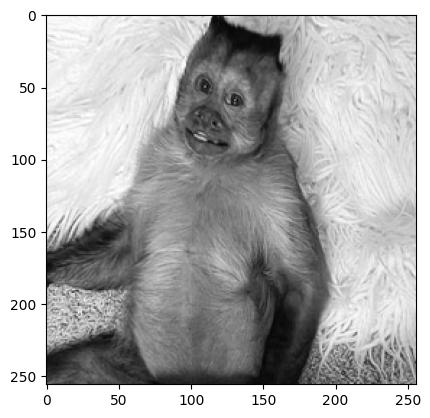

In [17]:
from lib.inpainting import *

image = load("lib/george.jpg") #FILL IN FILE NAME

With this image in hand, let us subsample it and try to reconstruct the original.

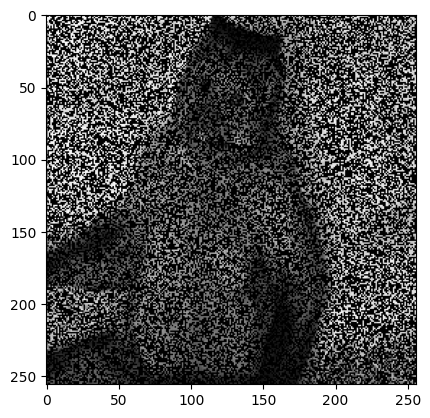

In [18]:
subsampled = show_subsampled(image)

For the rest of the questions, to ensure the function is 
$\mu$-strongly convex, we need to add an $\ell_2$ regularization term to it. As a result, we change the definition of $f_{\ell_1}(\mathbf{\alpha})$ as follows:
$$
    f_{\ell_1}(\mathbf{\alpha}) = \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2 + \frac{1}{2}\mu \|\mathbf{\alpha}\|_2^2 
    $$

and the composite function becomes:
 $$
    \min_{\mathbf{\alpha} \in \mathbb{R}^{p}} \underbrace{ \frac{1}{2}\|\mathbf{b} - \mathbf{P}_{\Omega} \mathbf{W}^T\mathbf{\alpha} \|_2^2 + \frac{1}{2}\mu \|\mathbf{\alpha}\|_2^2 }_{f_{\ell_1}(\mathbf{\alpha})} + \underbrace{\lambda_{\ell_1} \|\mathbf{\alpha}\|_1}_{g_{\ell_1}(\mathbf{\alpha})},
    $$

By adding this regularization, we ensure better properties for optimization, making the solution more stable and well-behaved.

In the following cells we will define the optimization problems we need to solve to perform the reconstruction.

- We provide you with a function `P` that acts like the matrix $\mathbf{P}_{\Omega}$. That is, given a vector `x`, it returns a subsampled vector `P(x)` that corresponds to $\mathbf{P}_{\Omega} \mathbf{x}$. We also give you `P_T` which acts like $\mathbf{P}^\top$.
- We provide you with a function `W` and `W_T` that act like the matrix $\mathbf{W}$ and $\mathbf{W^\top}$ respectively. That is, for a vector `x`, `W(x)` and `W_T(x)` return $\mathbf{W}\mathbf{x}$ and $\mathbf{W^\top}\mathbf{x}$ respectively.

__(a)__ (1 point) Using these provided functions, define the observed variable `b` in the cell below.

In [19]:
from lib.inpainting import P, P_T, W, W_T

x = image.reshape(-1) #flattened image

b = P(x).reshape(-1)

__(b)__ (1 point) Now define the function `f_l1` as described earlier in the problem text.

In [20]:
mu = 1e-4 # Desired strong convexity of f
def f_l1(alpha):
    return (1/2) * np.linalg.norm(b - P(W_T(alpha)), ord=2)**2 + (1/2) * mu * (np.linalg.norm(alpha, ord=2) ** 2)

__(c)__ (1 point) Write the gradient of $f_{\ell_1}(\mathbf{\alpha})$.

In [21]:
def grad_f_l1(alpha):
    return -W(P_T(b - P(W_T(alpha)))) + mu * alpha

__(d)__ (1 points) Find the Lipschitz constant of $\nabla_\mathbf{\alpha} f_{\ell_1}(\mathbf{\alpha})$ analytically and fill it in the cell below. 

We start finding the Hessian:
$$ f_{\ell_1}(\alpha) = \frac{1}{2} ||b - P_\Omega W^T\alpha||^2_2 + \frac{1}{2} \mu ||\alpha||^2_2 $$
$$ \nabla f_{\ell_1}(\alpha) = -W P_\Omega^T(b - P_\Omega W^T\alpha) + \mu \alpha $$
$$ \nabla^2 f_{\ell_1}(\alpha) = W P_\Omega^T P_\Omega W^T + \mu * I $$

$f_{\ell_1}$ has a Lipschitz gradient:
$$ \mu I \preceq \nabla^2 f_{\ell_1}(x) \preceq L \cdot I $$
$$ L = \lambda_{\max}(W P_\Omega^T P_\Omega W^T + \mu) $$

We have to note that each row in matrix $P_\Omega$ contains exactly one element equal to 1 with zeros elsewhere. Additionally, since it samples different pixels, no two rows can have a 1 in the same column position. This means that $P_\Omega P_\Omega^T = I$ and $P_\Omega^T P_\Omega$ is a diagonal matrix with 0's and 1's in it, thus, the eigenvalues are 0 and 1. We also consider the orthogonality of the wavelet basis $W$ ($WW^T = I$), this $W P_\Omega^T P_\Omega W^T$ resembles the SVD decomposition, where $P_\Omega^T P_\Omega$ contains the singular values, and since it is a real symmetric matrix, the singular values are the eigenvalues.

Now, given these facts, we can compute the maximun eigenvalue (where the numbers in the diagonal are added with $\mu$):
$$ L = \lambda_{\max}(W P_\Omega^T P_\Omega W^T + \mu I) =  1 + \mu $$

In [22]:
lips_grad_f_l1 = 1 + mu

We have all the necessary ingredients to define the smooth part of our composite objective:

In [23]:
f_l1 = Function(f = f_l1, grad=grad_f_l1, lips_grad = lips_grad_f_l1, strng_cvx=mu)

For the non-smooth term, we define a regularizer built around the `l1` function that re-uses the `l1_prox` function you implemented earlier:

In [24]:
l1 = Function(f = lambda x: np.sum(np.abs(x), axis=0), prox=l1_prox)

g_l1 = Regularizer(l1)

In [25]:
composite_objective = CompositeFunction(f=f_l1, g=g_l1)

With the objective defined, we provide you with a function with the following signature:
```python
solve_composite(method: OptAlgorithm, composite_objective: CompositeFunction, lmda: float, max_iterations: int) -> Vector
```

In other words, the function takes an optimization algorithm `method`, a CompositeFunction `composite_objective`, a regularization parameter `lmda` and a number of iterations `max_iterations` and returns a vector which is the last iterate given by the `method`.



In [26]:
from lib.inpainting import solve_composite

__(e)__ (5 points) Using `solve_composite` reconstruct the subsampled image. Recall that the composite problem solves for $\mathbf{\alpha}$ so you need to convert the output back to an image and visualize it.

Select a reasonable value for `lmda` or (BONUS) using the function `solve_composite` and the `PSNR` metric, find the best value for `lmda`.

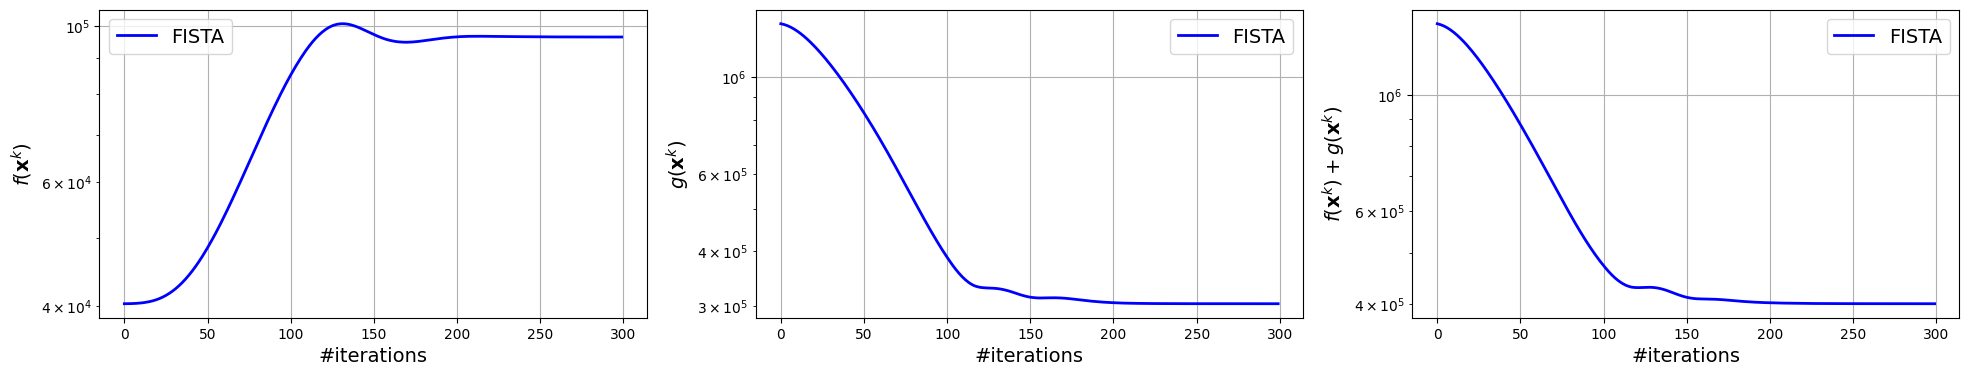

In [27]:
output = solve_composite(FISTA, composite_objective, 0.3, 300) # alpha
flat_image_out = W_T(output)
image_out = flat_image_out.reshape(image.shape)

In [28]:
# We explore different values of lambda to find the best one

lambdas = np.linspace(0.05, 0.99, 15)

results = []

for l in lambdas:
    plt.close()
    output = solve_composite(FISTA, composite_objective, l, 300)
    flat_image_out = W_T(output)
    image_out = flat_image_out.reshape(image.shape)

    mse = np.mean((image_out - image) ** 2)
    psnr = 20 * np.log10(255.0 / np.sqrt(mse))

    results.append((output, l, mse, psnr))
    plt.close()

best_result = max(results, key=lambda x: x[3])
output, best_lambda, best_mse, best_psnr = best_result
print(f'Best result: Lambda = {best_lambda}, MSE = {best_mse}, PSNR = {best_psnr}')

Best result: Lambda = 0.99, MSE = 187.6404403698486, PSNR = 25.39753917353977


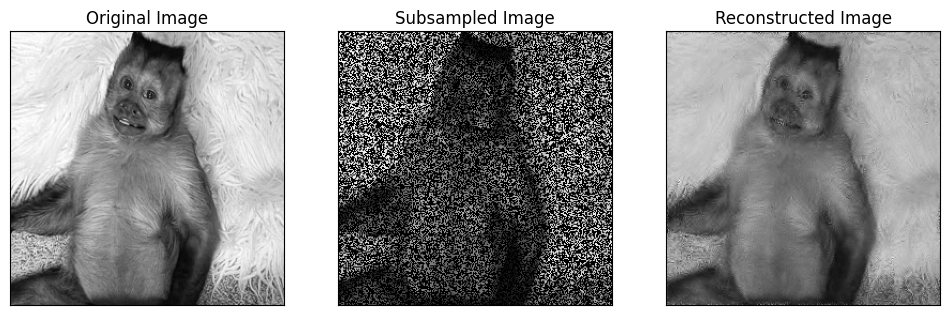

In [29]:
show(true = image, subsampled=subsampled, estimated=image_out)